In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio # We only need the Audio 'Class' from this package

In [2]:
def sine_gen(amplitude, frequency, phase, duration, sample_rate):
    t_v = np.arange(0, duration, 1/sample_rate) 
    output = amplitude * np.sin(2 * np.pi * frequency * t_v + phase)
    return output

In [3]:
def normalize(x):
    maxVal = 0;
    for i in range (len(x)):
        if x[i] > maxVal:
            maxVal = x[i]
    return x/maxVal

In [4]:
class ADSR:
    #value is percentage of length of the signal
    #for example: attack of 0.2, decay of 0.25 means the signal will peak 20% of the way in
    #and reach the sustain level at 45% of the way in
    attack = 0.1
    decay = 0.1
    sustain = 1
    #release is a percentage of the signal left over
    release = 0
    
    def generateADSR(self, length, sr):
        #find length in samples of attack, decay, sustain and release periods
        attackLength = (int)(length*sr*self.attack)
        decayLength = (int)(length*sr*self.decay)
        releaseLength = (int)(((length*sr)-(attackLength+decayLength))*self.release)
        sustainLength = (int)((length*sr)-(attackLength+decayLength+releaseLength))
        
        #create the ADSR array
        adsr = np.zeros(length*sr)
        adsr[0:attackLength] = np.linspace(0,1,attackLength)
        adsr[attackLength:attackLength+decayLength] = np.linspace(1,self.sustain,decayLength)
        adsr[attackLength+decayLength:attackLength+decayLength+sustainLength] = [self.sustain]*sustainLength
        adsr[attackLength+decayLength+sustainLength:] = np.linspace(self.sustain,0,releaseLength)
        
        return adsr

In [5]:
class Operator:
    frequency = 0
    adsr = ADSR()
    amplitude = 0
    modLFO = 0 #how much the operator is modulated by the LFO
    
    #create a new operator
    def __init__(self, f, a):
        self.adsr = ADSR()
        self.frequency = f
        self.amplitude = a
        self.setAdsr(0,0,1,0)
    
    #modulator is a signal that will be input
    def generateModulatedSignal(self, length, sr, modulator):
        
        k = 10 #for now, update this later
        t_v = np.arange(0, length, 1/sr)
        carrier = 2*np.pi*(self.frequency)*t_v
        
        #generate modulated wave
        modulated_wave = np.cos(carrier + k*modulator)
        
        #normalize
        modulated_wave = self.amplitude * normalize(modulated_wave)
        
        #apply ADSR
        modulated_wave = modulated_wave * self.adsr.generateADSR(length, sr)
        return modulated_wave
    
    #this will be used to create signals that have no FM input
    def generateUnmodulatedSignal(self, length, sr):
        wave = sine_gen(self.amplitude, self.frequency, 0, length, sr)
        wave = wave * self.adsr.generateADSR(length, sr)
        return wave
        
    #sets the attack, decay, sustain, and release of the envelope for this channel
    def setAdsr(self, a, d, s, r):
        self.adsr.attack = a
        self.adsr.decay = d
        self.adsr.sustain = s
        self.adsr.release = r

In [6]:
#THIS IS A CLASS FOR OPERATOR 1
#Operator 1 has the ability to feed back into itself

class FeedbackOperator(Operator):
    
    #feedback should be between 0 and 1
    feedback = 0
    
    #the degree to which this operator will be modulated by the LFO
    modLFO = 0
    
    def __init__(self):
        self.frequency = 440
    
    def __init__(self, f, a, fb):
        self.adsr = ADSR()
        self.setAdsr(0,0,1,0)
        self.frequency = f
        self.amplitude = a
        self.feedback = fb    
    
    def generateUnmodulatedSignal(self, length, sr):
        wave = sine_gen(self.feedback, self.frequency, 0, length, sr)
        feedback_wave = Operator.generateModulatedSignal(self, length, sr, wave)
        feedback_wave = feedback_wave * self.adsr.generateADSR(length, sr)
        return feedback_wave

In [7]:
def testAlgorithm(op1, op2, sr):
    modulator = op1.generateUnmodulatedSignal(1, sr)
    output = op2.generateModulatedSignal(1, sr, modulator)
    return output

In [8]:
def testAlgorithm2(length, sr, op1, op2, op3):
    modulator1 = op1.generateUnmodulatedSignal(length, sr)
    modulator2 = op2.generateModulatedSignal(length,sr,modulator1)
    output = op3.generateModulatedSignal(length, sr, modulator2)
    return output

In [9]:
def algorithm0(length, sr, op1, op2, op3, op4):
    #op4 is a slot, others are modulators
    modulator1 = op1.generateUnmodulatedSignal(length,sr)
    modulator2 = op2.generateModulatedSignal(length,sr,modulator1)
    modulator3 = op3.generateModulatedSignal(length,sr,modulator2)
    output = op4.generateModulatedSignal(length,sr,modulator3)
    
    return output

In [10]:
def algorithm1(length, sr, op1, op2, op3, op4):
    #op4 is a slot, others are modulators
    #op1 and op2 sum to modulate op3, which modulates op4
    modulator1 = op1.generateUnmodulatedSignal(length,sr)
    modulator2 = op2.generateUnmodulatedSignal(length,sr)
    modulator3 = op3.generateModulatedSignal(length,sr,modulator1 + modulator2)
    output = op4.generateModulatedSignal(length,sr,modulator3)
    
    return output

In [11]:
def algorithm2(length, sr, op1, op2, op3, op4):
    #op4 is a slot, others are modulators
    #op2 mods op3, op1 and op3 sum to mod op4
    modulator1 = op1.generateUnmodulatedSignal(length,sr)
    modulator2 = op2.generateUnmodulatedSignal(length,sr)
    modulator3 = op3.generateModulatedSignal(length,sr,modulator2)
    output = op4.generateModulatedSignal(length,sr,modulator2 + modulator3)
    
    return output

In [12]:
def algorithm3(length, sr, op1, op2, op3, op4):
    #op4 is a slot, others are modulators
    #op1 mods op2, op2 and op3 sum to mod op4
    modulator1 = op1.generateUnmodulatedSignal(length,sr)
    modulator2 = op2.generateModulatedSignal(length,sr,modulator1)
    modulator3 = op3.generateUnmodulatedSignal(length,sr)
    
    output = op4.generateModulatedSignal(length,sr,modulator2 + modulator3)
    
    return output

In [13]:
def algorithm4(length, sr, op1, op2, op3, op4):
    #op2 and op4 are slots, others are modulators
    #op1 mods op2, op3 mods op4
    modulator1 = op1.generateUnmodulatedSignal(length,sr)
    slot2 = op2.generateModulatedSignal(length,sr,modulator1)
    modulator3 = op3.generateUnmodulatedSignal(length,sr)
    slot4 = op4.generateModulatedSignal(length,sr,modulator3)
    
    output = normalize(slot2 + slot4)
    
    return output

In [14]:
def algorithm5(length, sr, op1, op2, op3, op4):
    #op2, op3, and op4 are slots, op1 is a modulator
    #op1 mods op2, op3, and mo4
    modulator1 = op1.generateUnmodulatedSignal(length,sr)
    slot2 = op2.generateModulatedSignal(length,sr,modulator1)
    slot3 = op3.generateModulatedSignal(length,sr,modulator1)
    slot4 = op4.generateModulatedSignal(length,sr,modulator1)
    
    output = normalize(slot2 + slot3 + slot4)
    
    return output

In [15]:
def algorithm6(length, sr, op1, op2, op3, op4):
    #op2, op3, and op4 are slots, op1 is a modulator
    #op1 mods op2 - op3 and op4 are unmodulated
    modulator1 = op1.generateUnmodulatedSignal(length,sr)
    slot2 = op2.generateModulatedSignal(length,sr,modulator1)
    slot3 = op3.generateUnmodulatedSignal(length,sr)
    slot4 = op4.generateUnmodulatedSignal(length,sr)
    
    output = normalize(slot2 + slot3 + slot4)
    
    return output

In [16]:
def algorithm7(length, sr, op1, op2, op3, op4):
    #all operators are unmodualted slots
    slot1 = op1.generateUnmodulatedSignal(length,sr)
    slot2 = op2.generateUnmodulatedSignal(length,sr)
    slot3 = op3.generateUnmodulatedSignal(length,sr)
    slot4 = op4.generateUnmodulatedSignal(length,sr)
    
    output = normalize(slot1 + slot2 + slot3 + slot4)
    
    return output

In [17]:
class Channel:
    op1 = FeedbackOperator(440, 1, 0.5)
    op2 = Operator(440, 1)
    op3 = Operator(440, 1)
    op4 = Operator(440, 1)
    
    algorithm = None
    
    length = 1
    sr = 48000
    
    #initialize LFO to just 1s
    LFO = [0] * (length*sr)
    
    #constructor with 4 pre-made operators
    def __init__(self, o1, o2, o3, o4):
        self.op1 = o1
        self.op2 = o2
        self.op3 = o3
        self.op4 = o4
        self.setAlgorithm(0)
        self.setLFO(0,5)
        
    #choose which algorithm the channel will use
    def setAlgorithm(self, algo):
        if (algo == 0):
            self.algorithm = self.algorithm0
        elif (algo == 1):
            self.algorithm = self.algorithm1
        elif (algo == 2):
            self.algorithm = self.algorithm2
        elif (algo == 3):
            self.algorithm = self.algorithm3
        elif (algo == 4):
            self.algorithm = self.algorithm4
        elif (algo == 5):
            self.algorithm = self.algorithm5
        elif (algo == 6):
            self.algorithm = self.algorithm5
        elif (algo == 7):
            self.algorithm = self.algorithm5
            
    #set LFO based on a given frequency and amplitude
    def setLFO(self, freq, amp):
        self.LFO = sine_gen(amp, freq, 0, self.length, sr)
        
    #get the channel to generate a sound with the given algorith, operators, and LFO
    def generateSound(self):
        audio = self.algorithm(self.length, self.sr, self.op1, self.op2, self.op3, self.op4)
        print(len(audio))
        return(audio)
        #Audio(audio, rate = self.sr)
        
        
    #ALGORITHMS
    #These are the same as the standalone functions above, but with LFO modulation
    def algorithm0(self, length, sr, op1, op2, op3, op4):
        #op4 is a slot, others are modulators
        
        modulator1 = op1.generateUnmodulatedSignal(length,sr)
        #apply LFO to op1
        modulator1 = modulator1 * (([1] * (length*sr)) + (self.LFO * op1.modLFO))
        
        modulator2 = op2.generateModulatedSignal(length,sr,modulator1)
        #apply LFO to op2
        modulator2 = modulator2 * (([1] * (length*sr)) + (self.LFO * op2.modLFO))
        
        modulator3 = op3.generateModulatedSignal(length,sr,modulator2)
        #apply LFO to op3
        modulator3 = modulator3 * (([1] * (length*sr)) + (self.LFO * op3.modLFO))
        
        output = op4.generateModulatedSignal(length,sr,modulator3)
        #apply LFO to op4
        output = output * (([1] * (length*sr)) + (self.LFO * op4.modLFO))

        return output
    
    def algorithm1(self, length, sr, op1, op2, op3, op4):
        #op4 is a slot, others are modulators
        #op1 and op2 sum to modulate op3, which modulates op4
        
        modulator1 = op1.generateUnmodulatedSignal(length,sr)
        #apply LFO to op1
        modulator1 = modulator1 * (([1] * (length*sr)) + (self.LFO * op1.modLFO))
        
        modulator2 = op2.generateUnmodulatedSignal(length,sr)
        #apply LFO to op2
        modulator2 = modulator2 * (([1] * (length*sr)) + (self.LFO * op2.modLFO))
        
        modulator3 = op3.generateModulatedSignal(length,sr,modulator1 + modulator2)
        #apply LFO to op3
        modulator3 = modulator3 * (([1] * (length*sr)) + (self.LFO * op3.modLFO))
        
        output = op4.generateModulatedSignal(length,sr,modulator3)
        #apply LFO to op4
        output = output * (([1] * (length*sr)) + (self.LFO * op4.modLFO))

        return output
    
    def algorithm2(self, length, sr, op1, op2, op3, op4):
        #op4 is a slot, others are modulators
        #op2 mods op3, op1 and op3 sum to mod op4
        
        modulator1 = op1.generateUnmodulatedSignal(length,sr)
        #apply LFO to op1
        modulator1 = modulator1 * (([1] * (length*sr)) + (self.LFO * op1.modLFO))
        
        modulator2 = op2.generateUnmodulatedSignal(length,sr)
        #apply LFO to op2
        modulator2 = modulator2 * (([1] * (length*sr)) + (self.LFO * op2.modLFO))
        
        modulator3 = op3.generateModulatedSignal(length,sr,modulator2)
        #apply LFO to op3
        modulator3 = modulator3 * (([1] * (length*sr)) + (self.LFO * op3.modLFO))
        
        output = op4.generateModulatedSignal(length,sr,modulator2 + modulator3)
        #apply LFO to op4
        output = output * (([1] * (length*sr)) + (self.LFO * op4.modLFO))

        return output
    
    def algorithm3(self, length, sr, op1, op2, op3, op4):
        #op4 is a slot, others are modulators
        #op1 mods op2, op2 and op3 sum to mod op4
        
        modulator1 = op1.generateUnmodulatedSignal(length,sr)
        #apply LFO to op1
        modulator1 = modulator1 * (([1] * (length*sr)) + (self.LFO * op1.modLFO))
        
        modulator2 = op2.generateModulatedSignal(length,sr,modulator1)
        #apply LFO to op2
        modulator2 = modulator2 * (([1] * (length*sr)) + (self.LFO * op2.modLFO))
        
        modulator3 = op3.generateUnmodulatedSignal(length,sr)
        #apply LFO to op3
        modulator3 = modulator3 * (([1] * (length*sr)) + (self.LFO * op3.modLFO))

        output = op4.generateModulatedSignal(length,sr,modulator2 + modulator3)
        #apply LFO to op4
        output = output * (([1] * (length*sr)) + (self.LFO * op4.modLFO))

        return output
    
    def algorithm4(self, length, sr, op1, op2, op3, op4):
        #op2 and op4 are slots, others are modulators
        #op1 mods op2, op3 mods op4
        
        modulator1 = op1.generateUnmodulatedSignal(length,sr)
        #apply LFO to op1
        modulator1 = modulator1 * (([1] * (length*sr)) + (self.LFO * op1.modLFO))
        
        slot2 = op2.generateModulatedSignal(length,sr,modulator1)
        #apply LFO to op2
        slot2 = slot2 * (([1] * (length*sr)) + (self.LFO * op2.modLFO))
        
        modulator3 = op3.generateUnmodulatedSignal(length,sr)
        #apply LFO to op3
        modulator3 = modulator3 * (([1] * (length*sr)) + (self.LFO * op3.modLFO))
        
        slot4 = op4.generateModulatedSignal(length,sr,modulator3)
        #apply LFO to op2
        slot4 = slot4 * (([1] * (length*sr)) + (self.LFO * op4.modLFO))

        output = normalize(slot2 + slot4)

        return output
    
    def algorithm5(self, length, sr, op1, op2, op3, op4):
        #op2, op3, and op4 are slots, op1 is a modulator
        #op1 mods op2, op3, and mo4
        modulator1 = op1.generateUnmodulatedSignal(length,sr)
        #apply LFO to op1
        modulator1 = modulator1 * (([1] * (length*sr)) + (self.LFO * op1.modLFO))
        
        slot2 = op2.generateModulatedSignal(length,sr,modulator1)
        #apply LFO to op2
        slot2 = slot2 * (([1] * (length*sr)) + (self.LFO * op2.modLFO))
        
        slot3 = op3.generateModulatedSignal(length,sr,modulator1)
        #apply LFO to op3
        slot3 = slot3 * (([1] * (length*sr)) + (self.LFO * op2.modLFO))
        
        slot4 = op4.generateModulatedSignal(length,sr,modulator1)
        #apply LFO to op2
        slot4 = slot4 * (([1] * (length*sr)) + (self.LFO * op4.modLFO))

        output = normalize(slot2 + slot3 + slot4)

        return output
    
    def algorithm6(self, length, sr, op1, op2, op3, op4):
        #op2, op3, and op4 are slots, op1 is a modulator
        #op1 mods op2 - op3 and op4 are unmodulated
        
        modulator1 = op1.generateUnmodulatedSignal(length,sr)
        #apply LFO to op1
        modulator1 = modulator1 * (([1] * (length*sr)) + (self.LFO * op1.modLFO))
        
        slot2 = op2.generateModulatedSignal(length,sr,modulator1)
        #apply LFO to op2
        slot2 = slot2 * (([1] * (length*sr)) + (self.LFO * op2.modLFO))
        
        slot3 = op3.generateUnmodulatedSignal(length,sr)
        #apply LFO to op3
        slot3 = slot3 * (([1] * (length*sr)) + (self.LFO * op2.modLFO))
        
        slot4 = op4.generateUnmodulatedSignal(length,sr)
        #apply LFO to op2
        slot4 = slot4 * (([1] * (length*sr)) + (self.LFO * op4.modLFO))

        output = normalize(slot2 + slot3 + slot4)

        return output
    
    def algorithm7(self, length, sr, op1, op2, op3, op4):
        #all operators are unmodualted slots
        
        slot1 = op1.generateUnmodulatedSignal(length,sr)
        #apply LFO to op1
        slot1 = slot1 * (([1] * (length*sr)) + (self.LFO * op2.modLFO))
        
        slot2 = op2.generateUnmodulatedSignal(length,sr)
        #apply LFO to op2
        slot2 = slot2 * (([1] * (length*sr)) + (self.LFO * op2.modLFO))
        
        slot3 = op3.generateUnmodulatedSignal(length,sr)
        #apply LFO to op3
        slot3 = slot3 * (([1] * (length*sr)) + (self.LFO * op2.modLFO))
        
        slot4 = op4.generateUnmodulatedSignal(length,sr)
        #apply LFO to op2
        slot4 = slot4 * (([1] * (length*sr)) + (self.LFO * op4.modLFO))

        output = normalize(slot1 + slot2 + slot3 + slot4)

        return output

48000


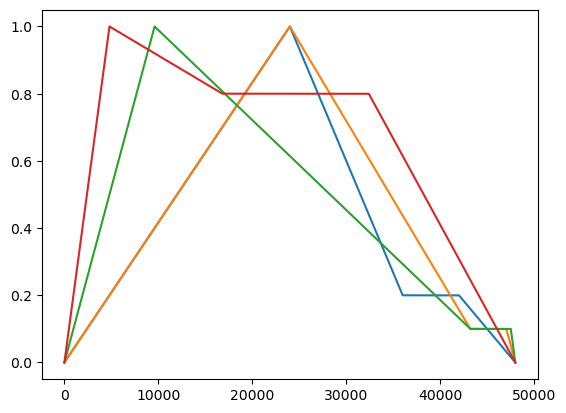

In [26]:
sr = 48000

#GENERATE SOUNDS HERE

#create the 4 operators to be used
operator1 = FeedbackOperator(220, 0.5, 0.2) #frequency, amplitude, feedback
operator1.setAdsr(0.5,0.25,0.2,0.5)
operator1.modLFO = 1

operator2 = Operator(220, 1) #frequency, amplitude
operator2.setAdsr(0.5,0.4,0.1,0.2)
operator2.modLFO = 0

operator3 = Operator(165, 0.7)
operator3.setAdsr(0.2,0.7,0.1,0.1)
operator3.modLFO = 0

operator4 = Operator(220, 1)
operator4.setAdsr(0.1,0.25,0.8,0.5)
operator4.modLFO = 1

#create a sound channel from these 4 operators
channel = Channel(operator1, operator2, operator3, operator4)
channel.length = 1
channel.setLFO(1,0.5)
channel.setAlgorithm(0)
channelSound = channel.generateSound()

plt.plot(operator1.adsr.generateADSR(1,sr))
plt.plot(operator2.adsr.generateADSR(1,sr))
plt.plot(operator3.adsr.generateADSR(1,sr))
plt.plot(operator4.adsr.generateADSR(1,sr))
#plt.plot(channel.LFO)

Audio(channelSound, rate=sr)